In [1]:
!pip install opencv-python matplotlib


Saving my car .jpg to my car  (1).jpg


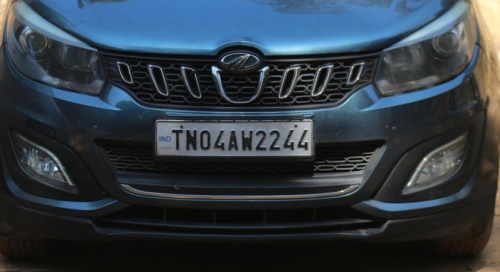

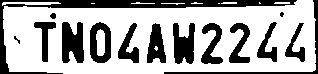

✅ Number Plate Detected: TNOLAW2244


In [ ]:
import numpy as np
import cv2
import pytesseract
import imutils
import pandas as pd
import time
from google.colab.patches import cv2_imshow
from google.colab import files
import os

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Safe image read
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"❌ Could not load image: {image_path}. Please check the file format and path.")

# Resize for consistent processing
image = imutils.resize(image, width=500)
cv2_imshow(image)

# Preprocessing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 170, 200)

# Contour detection
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]
NumberPlateCnt = None

# Find 4-point contour
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        NumberPlateCnt = approx
        break

mask = np.zeros(gray.shape, np.uint8)

if NumberPlateCnt is not None:
    # Mask and crop the plate region
    cv2.drawContours(mask, [NumberPlateCnt], 0, 255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)

    x, y, w, h = cv2.boundingRect(NumberPlateCnt)
    plate_crop = new_image[y:y+h, x:x+w]

    # Resize and sharpen
    plate_crop = cv2.resize(plate_crop, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    plate_gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Display cropped plate
    cv2_imshow(plate_thresh)

    # OCR configuration
    config = ('-l eng --oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    text = pytesseract.image_to_string(plate_thresh, config=config).strip()
    print("✅ Number Plate Detected:", text)
else:
    print("⚠️ No plate contour found. Running OCR on whole image.")
    config = ('-l eng --oem 3 --psm 6')
    text = pytesseract.image_to_string(image, config=config).strip()
    print("🔍 OCR result:", text)

# Save to CSV
raw_data = {'date': [time.asctime(time.localtime(time.time()))], 'v_number': [text]}
df = pd.DataFrame(raw_data)
df.to_csv('vehicle_number.csv', mode='a', header=not os.path.exists('vehicle_number.csv'), index=False)


In [2]:
!pip install pytesseract